# RELAX: Representation Learning Explainability

This notebook illustrates the usage of RELAX, a framework for explainability in representation learning. RELAX is based on measuring similarities in the representation space between an input and occluded versions of itself. Our analysis of RELAX shows that the proposed method can be considered a linear scoring function in a reproducing kernel Hilbert space in the form of an inner produced product between unmasked input and the mean of the masked representations. For more information see the [International Journal of Computer Vision paper](https://link.springer.com/article/10.1007/s11263-023-01773-2#citeas) or the [ArXiv paper](https://arxiv.org/pdf/2112.10161.pdf).







In [1]:
#@title Download example image

#@markdown We download an image of a bird from https://commons.wikimedia.org to illustrate the usage of RELAX.

!wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Tringa_totanus-pjt.jpg/640px-Tringa_totanus-pjt.jpg'



--2025-03-28 11:28:56--  https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Tringa_totanus-pjt.jpg/640px-Tringa_totanus-pjt.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26773 (26K) [image/jpeg]
Saving to: ‘640px-Tringa_totanus-pjt.jpg.1’

640px-Tringa_totanu 100%[===================>]  26.15K  --.-KB/s    in 0.05s   

2025-03-28 11:28:56 (556 KB/s) - ‘640px-Tringa_totanus-pjt.jpg.1’ saved [26773/26773]



In [3]:
#@title Load packages

import torch
import torchvision
import torch.nn as nn
import tqdm.notebook as tqdm
import torch.nn.functional as F
import matplotlib.gridspec as gridspec

from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import pil_to_tensor
from torchvision.transforms import ToTensor, Normalize, Resize


In [4]:
#@title Function for rescaling and displaying images.
#@markdown This function is taken from the TorchRay library (https://github.com/facebookresearch/TorchRay).

def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                                *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap

In [5]:
#@title Functions from utilities folder in RELAX repository


IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

def imagenet_image_transforms(device: str, new_shape_of_image: int = 224):
    """
    Returns transformations that takes a torch tensor and transforms it into a new tensor
    of size (1, C, new_shape_of_image, new_shape_of_image), normalizes the image according
    to the statistics from the Imagenet dataset, and puts the tensor on the desired device.
    """
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((new_shape_of_image, new_shape_of_image)),
        torchvision.transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        torchvision.transforms.Lambda(unsqeeze_image),
        ToDevice(device),
    ])

    return transform

class ToDevice(torch.nn.Module):
    """
    Sends the input object to the device specified in the
    object's constructor by calling .to(device) on the object.
    """
    def __init__(self, device):
        super().__init__()
        self.device = device

    def forward(self, img):
        return img.to(self.device)

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(device={self.device})"

def unsqeeze_image(input_image: torch.Tensor) -> torch.Tensor:
    return input_image.unsqueeze(0)

In [6]:
#@title Functions from masking functions folder in RELAX repository
#@markdown This function implements the generator for creating masks in our framework.
#@markdown The implementation is based on the TorchRay implementation and the
#@markdown RISE implementation at: https://github.com/eclique/RISE.

def mask_generator(
    batch_size: int,
    shape: tuple,
    device: str,
    num_cells: int = 7,
    probablity_of_drop: float = 0.5,
    num_spatial_dims: int = 2) -> torch.Tensor:
    """
    Generates a batch of masks by sampling Bernoulli random variables (probablity_of_drop) in a lower dimensional grid (num_cells)
    and upsamples the discrete masks using bilinear interpolation to obtain smooth continious mask in (0, 1).
    """

    pad_size = (num_cells // 2, num_cells // 2, num_cells // 2, num_cells // 2)

    grid = (torch.rand(batch_size, 1, *((num_cells,) * num_spatial_dims), device=device) < probablity_of_drop).float()
    grid_up = F.interpolate(grid, size=(shape), mode='bilinear', align_corners=False)
    grid_up = F.pad(grid_up, pad_size, mode='reflect')

    shift_x = torch.randint(0, num_cells, (batch_size,), device=device)
    shift_y = torch.randint(0, num_cells, (batch_size,), device=device)

    masks = torch.empty((batch_size, 1, shape[0], shape[1]), device=device)

    for mask_i in range(batch_size):
        masks[mask_i] = grid_up[
            mask_i,
            :,
            shift_x[mask_i]:shift_x[mask_i] + shape[0],
            shift_y[mask_i]:shift_y[mask_i] + shape[1]
        ]

    yield masks

In [7]:
#@title Class that implements the RELAX framework
from tqdm import tqdm

class RELAX(nn.Module):
    """
    Class for RELAX, a framework for explaining representations of data through masking and latent space similairty
    measurments.

    Link to ArXiv paper: https://arxiv.org/abs/2112.10161
    Link to International Journal of Computer Vision version: https://link.springer.com/article/10.1007/s11263-023-01773-2

    Parameters
    ----------
    input_image
        Input image to be explained.
    encoder
        Encoder that transforms the input image into a new representation
    batch_size
        The size of each batch of masks
    num_batches
        Number of batches with masks to generate
    similarity_measure
        Function for measuring similarity between masked and unmasked representation
    sum_of_weights_initial_value
        Initial values for running mean and variance estimator to avoid division by zero
    """
    def __init__(self,
                 input_image: torch.Tensor,
                 encoder: nn.Module,
                 batch_size: int = 100,
                 num_batches: int = 30,
                 similarity_measure: nn.Module = nn.CosineSimilarity(dim=1),
                 sum_of_weights_initial_value: float = 1e-10):

        super().__init__()

        self.batch_size = batch_size
        self.input_image = input_image
        self.num_batches = num_batches
        self.device = input_image.device
        self.encoder = encoder.to(self.device)
        self.similarity_measure = similarity_measure
        self.shape = tuple(input_image.shape[2:])
        self.unmasked_representations = encoder(self.input_image).expand(batch_size, -1)

        self.importance = torch.zeros(self.shape, device=self.device)
        self.uncertainty = torch.zeros(self.shape, device=self.device)

        self.sum_of_weights = sum_of_weights_initial_value*torch.ones(self.shape, device=self.device)

    def forward(self, **kwargs) -> None:
        
        for _ in range(self.num_batches):
            idx = 1
            for masks in  mask_generator(self.batch_size, self.shape, self.device, **kwargs):
                # print('Completed Masks ', idx, 'out of ', self.batch_size)
                idx += 1
                x_mask = self.input_image * masks
                # Print masked image
                # plt.imshow(imsc(x_mask.squeeze()))

                # print(x_mask.shape)

                masked_representations = self.encoder(x_mask)
                # print('Representation obtained')

                similarity_scores = self.similarity_measure(
                    self.unmasked_representations,
                    masked_representations
                )

                # print('Similarity scores obtained')

                for similarity_i, mask_i in zip(similarity_scores, masks.squeeze()):

                    self.sum_of_weights += mask_i

                    importance_previous_step = self.importance.clone()
                    self.importance += mask_i * (similarity_i - self.importance) / self.sum_of_weights
                    self.uncertainty += (similarity_i - self.importance) * (similarity_i - importance_previous_step) * mask_i

        return None

    @property
    def u_relax(self) -> torch.Tensor:
        return self.importance * (self.uncertainty <= self.uncertainty.median())

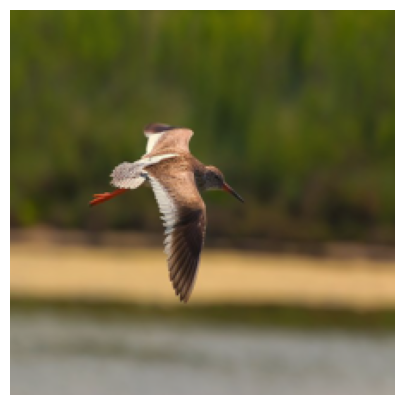

In [8]:
#@title Load and prepare example image
#@markdown This cell loads the image we download earlier and prepares the image
#@markdown by reshaping and normalizing into a suitable input format. We also
#@markdown plot the image to show what our bird looks like.

img = pil_to_tensor(Image.open('./640px-Tringa_totanus-pjt.jpg')).float()
img = imagenet_image_transforms(device='cpu', new_shape_of_image=224)(img)

plt.figure(1, figsize=(5, 5))
plt.imshow(imsc(img[0]))
plt.axis('off')
plt.show()


In [ ]:
#@title Load feature extractors
#@markdown This cell created functions for loading the feature extractors considered
#@markdown in this notebook. An image is represented by the output of the
#@markdown adaptive pooling layer towards the end of the Alexnet architecture.


def load_alexnet():
  alexnet = torchvision.models.alexnet(weights="DEFAULT")
  encoder = nn.Sequential(alexnet.features,
                          nn.AdaptiveAvgPool2d(output_size=(1, 1)),
                          nn.Flatten()).to('cpu')
  encoder.eval()
  return encoder




In [ ]:
#@title Run RELAX on example 1
#@markdown This cell runs RELAX on the example image we downloaded earlier.
#@markdown For all details on RELAX, please see our full paper.

encoder = load_alexnet()
relax = RELAX(img, encoder)

with torch.no_grad(): relax.forward()


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 217MB/s]  


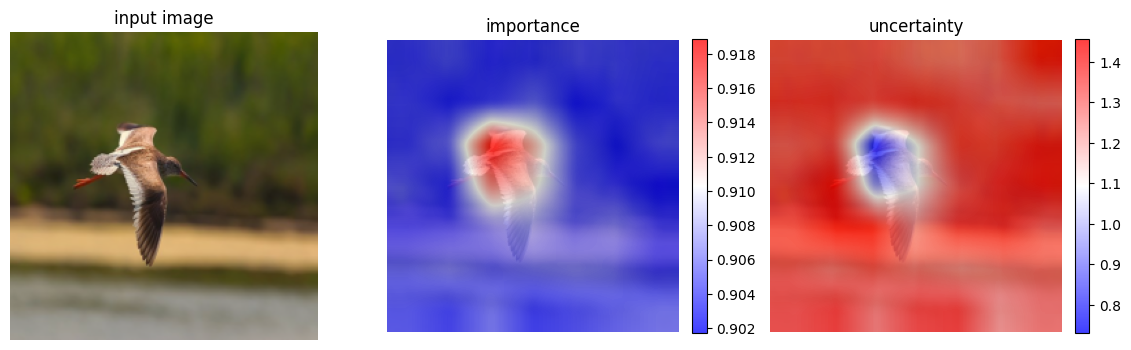

In [ ]:
#@title Display results
#@markdown Here we show what features in the input image are important
#@markdown for the representation of this image for the Alexnet encoder.
#@markdown It also shows the uncertainty associated with the uncertainty
#@markdown scores. In this simple example, the uncertainty analysis just
#@markdown shows that we are very certain about what the important pixels
#@markdown are. But in more complicated cases, the uncertainty estimates
#@markdown can provide valuable insights.

fig = plt.figure(figsize=(14, 4))
ax1 = fig.add_subplot(1, 3, 1)
im1 = ax1.imshow(imsc(img[0]))
ax1.axis('off')
ax1.set_title('input image')

ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(imsc(img[0]))
im2 = plt.imshow(relax.importance.numpy(force=True), alpha=0.75, cmap='bwr')
ax2.axis('off')
ax2.set_title('importance')
plt.colorbar(im2, fraction=0.046, pad=0.04)

ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(imsc(img[0]))
im3 = plt.imshow(relax.uncertainty.numpy(force=True), alpha=0.75, cmap='bwr')
ax3.axis('off')
ax3.set_title('uncertainty')
plt.colorbar(im3, fraction=0.046, pad=0.04)

plt.show()


In [ ]:
import torch.nn as nn
import torchvision.models as models

class BaseSimCLRException(Exception):
    """Base exception"""


class InvalidBackboneError(BaseSimCLRException):
    """Raised when the choice of backbone Convnet is invalid."""


class InvalidDatasetSelection(BaseSimCLRException):
    """Raised when the choice of dataset is invalid."""



class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(pretrained=False, num_classes=out_dim),
                            "resnet50": models.resnet50(pretrained=False, num_classes=out_dim)}

        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.fc.in_features

        # add mlp projection head
        self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
        except KeyError:
            raise InvalidBackboneError(
                "Invalid backbone architecture. Check the config file and pass one of: resnet18 or resnet50")
        else:
            return model

    def forward(self, x):
        return self.backbone(x)

In [ ]:
import sys
sys.path.append('../../src/SimCLR')
# from models.resnet_simclr import ResNetSimCLR

# m = ResNetSimCLR(base_model='resnet18', out_dim=128)

def load_simclr(model_path='/home/strawhat56/Desktop/Courses/Computer Vision/Project/cvProject/src/SimCLR/runs/Mar25_11-51-42_node3/checkpoint_1000.pth.tar'):
    model = ResNetSimCLR(base_model='resnet18', out_dim=128)
    model.load_state_dict(torch.load(model_path, map_location='cuda')['state_dict'])
    encoder = nn.Sequential(model.backbone)
    encoder.eval()
    return encoder

In [ ]:
img = img.to('cuda')
model = load_simclr(model_path='/kaggle/input/simclr-1000-checkpoint/other/default/1/checkpoint_1000.pth.tar').to('cuda')
relax = RELAX(img, model).to('cuda')

with torch.no_grad(): relax.forward()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-12-ed32b84a0d4e>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions

Files already downloaded and verified


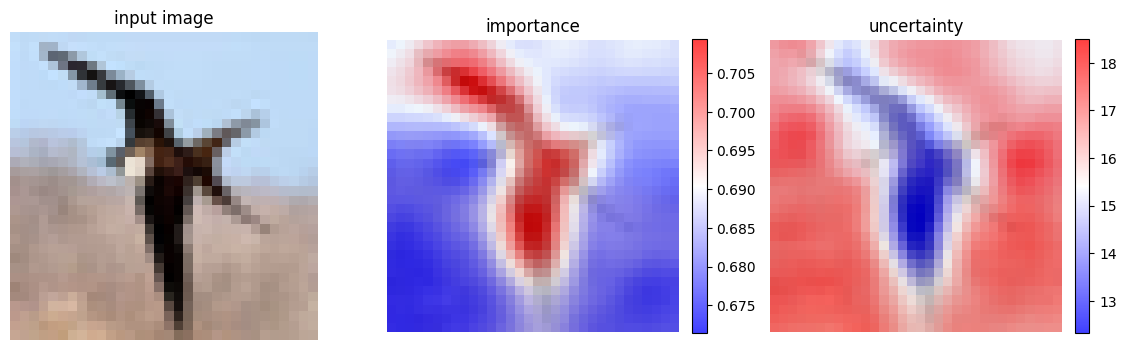

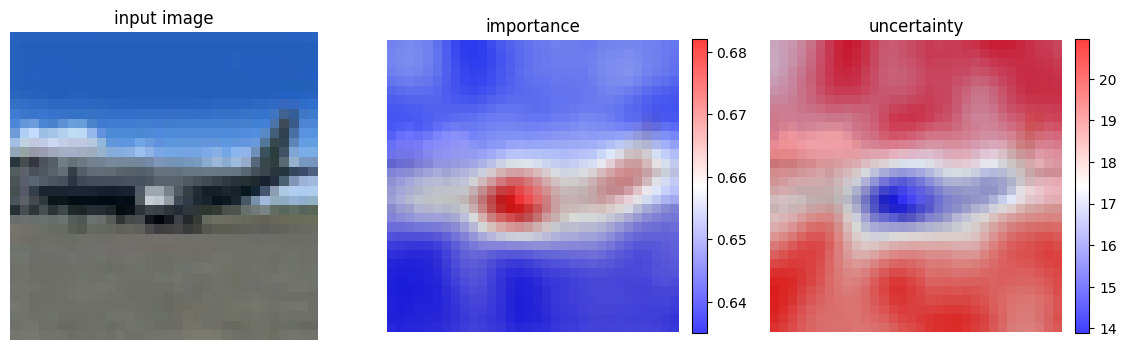

In [ ]:
# Load 10 images from the CIFAR-10 dataset
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)

dataiter = iter(trainloader)

images, labels = next(dataiter)

# For each image, we run RELAX and display the results

images = images.to('cuda')

for i in range(2):
    relax = RELAX(images[i].unsqueeze(0), model).to('cuda')
    with torch.no_grad(): relax.forward()

    fig = plt.figure(figsize=(14, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    im1 = ax1.imshow(imsc(images[i]))
    ax1.axis('off')
    ax1.set_title('input image')

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(imsc(images[i]))
    im2 = plt.imshow(relax.importance.numpy(force=True), alpha=0.75, cmap='bwr')
    ax2.axis('off')
    ax2.set_title('importance')
    plt.colorbar(im2, fraction=0.046, pad=0.04)

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(imsc(images[i]))
    im3 = plt.imshow(relax.uncertainty.numpy(force=True), alpha=0.75, cmap='bwr')
    ax3.axis('off')
    ax3.set_title('uncertainty')
    plt.colorbar(im3, fraction=0.046, pad=0.04)
    